In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
%matplotlib inline

In [2]:
def get_device():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return device

In [3]:
def relu_evidence(y):
    return F.relu(y)


def exp_evidence(y):
    return torch.exp(torch.clamp(y, -10, 10))


def softplus_evidence(y):
    return F.softplus(y)


def kl_divergence(alpha, num_classes, device=None):
    if not device:
        device = get_device()
    beta = torch.ones([1, num_classes], dtype=torch.float32, device=device)
    S_alpha = torch.sum(alpha, dim=1, keepdim=True)
    S_beta = torch.sum(beta, dim=1, keepdim=True)
    lnB = torch.lgamma(S_alpha) - torch.sum(torch.lgamma(alpha), dim=1, keepdim=True)
    lnB_uni = torch.sum(torch.lgamma(beta), dim=1, keepdim=True) - torch.lgamma(S_beta)
    dg0 = torch.digamma(S_alpha)
    dg1 = torch.digamma(alpha)
    kl = torch.sum((alpha - beta) * (dg1 - dg0), dim=1, keepdim=True) + lnB + lnB_uni
    return kl


def loglikelihood_loss(y, alpha, device=None):
    if not device:
        device = get_device()
    y = y.to(device)
    alpha = alpha.to(device)
    S = torch.sum(alpha, dim=1, keepdim=True)
    loglikelihood_err = torch.sum((y - (alpha / S)) ** 2, dim=1, keepdim=True)
    loglikelihood_var = torch.sum(alpha * (S - alpha) / (S * S * (S + 1)), dim=1, keepdim=True)
    loglikelihood = loglikelihood_err + loglikelihood_var
    return loglikelihood


def mse_loss(y, alpha, epoch_num, num_classes, annealing_step, device=None):
    if not device:
        device = get_device()
    y = y.to(device)
    alpha = alpha.to(device)
    loglikelihood = loglikelihood_loss(y, alpha, device=device)
    annealing_coef = torch.min(torch.tensor(1.0, dtype=torch.float32), torch.tensor(epoch_num / annealing_step, dtype=torch.float32))
    kl_alpha = (alpha - 1) * (1 - y) + 1
    kl_div = annealing_coef * kl_divergence(kl_alpha, num_classes, device=device)
    return loglikelihood + kl_div


def edl_loss(func, y, alpha, epoch_num, num_classes, annealing_step, device=None):
    y = y.to(device)
    alpha = alpha.to(device)
    S = torch.sum(alpha, dim=1, keepdim=True)
    A = torch.sum(y * (func(S) - func(alpha)), dim=1, keepdim=True)
    annealing_coef = torch.min(torch.tensor(1.0, dtype=torch.float32), torch.tensor(epoch_num / annealing_step, dtype=torch.float32))
    kl_alpha = (alpha - 1) * (1 - y) + 1
    kl_div = annealing_coef * kl_divergence(kl_alpha, num_classes, device=device)
    return A + kl_div


def edl_mse_loss(output, target, epoch_num, num_classes, annealing_step, device=None):
    if not device:
        device = get_device()
    evidence = relu_evidence(output)
    alpha = evidence + 1
    loss = torch.mean(mse_loss(target, alpha, epoch_num, num_classes, annealing_step, device=device))
    return loss


def edl_log_loss(output, target, epoch_num, num_classes, annealing_step, device=None):
    if not device:
        device = get_device()
    evidence = relu_evidence(output)
    alpha = evidence + 1
    loss = torch.mean(edl_loss(torch.log, target, alpha, epoch_num, num_classes, annealing_step, device))
    return loss


def edl_digamma_loss(output, target, epoch_num, num_classes, annealing_step, device=None):
    if not device:
        device = get_device()
    evidence = relu_evidence(output)
    alpha = evidence + 1
    loss = torch.mean(edl_loss(torch.digamma, target, alpha, epoch_num, num_classes, annealing_step, device))
    return loss


# Emperical comparison of loss function 

In [4]:
def calc_loss(alpha, label, epoch_num, num_classes):
    edl_mse = edl_mse_loss(alpha, label, epoch_num, num_classes, 3, "cpu")
    edl_log = edl_log_loss(alpha, label, epoch_num, num_classes, 3, "cpu")
    edl_digamma = edl_digamma_loss(alpha, label, epoch_num, num_classes, 3, "cpu")
    return edl_mse, edl_log, edl_digamma

**The label used for the experiment is [1,0,0] or [1,0,0,0]**

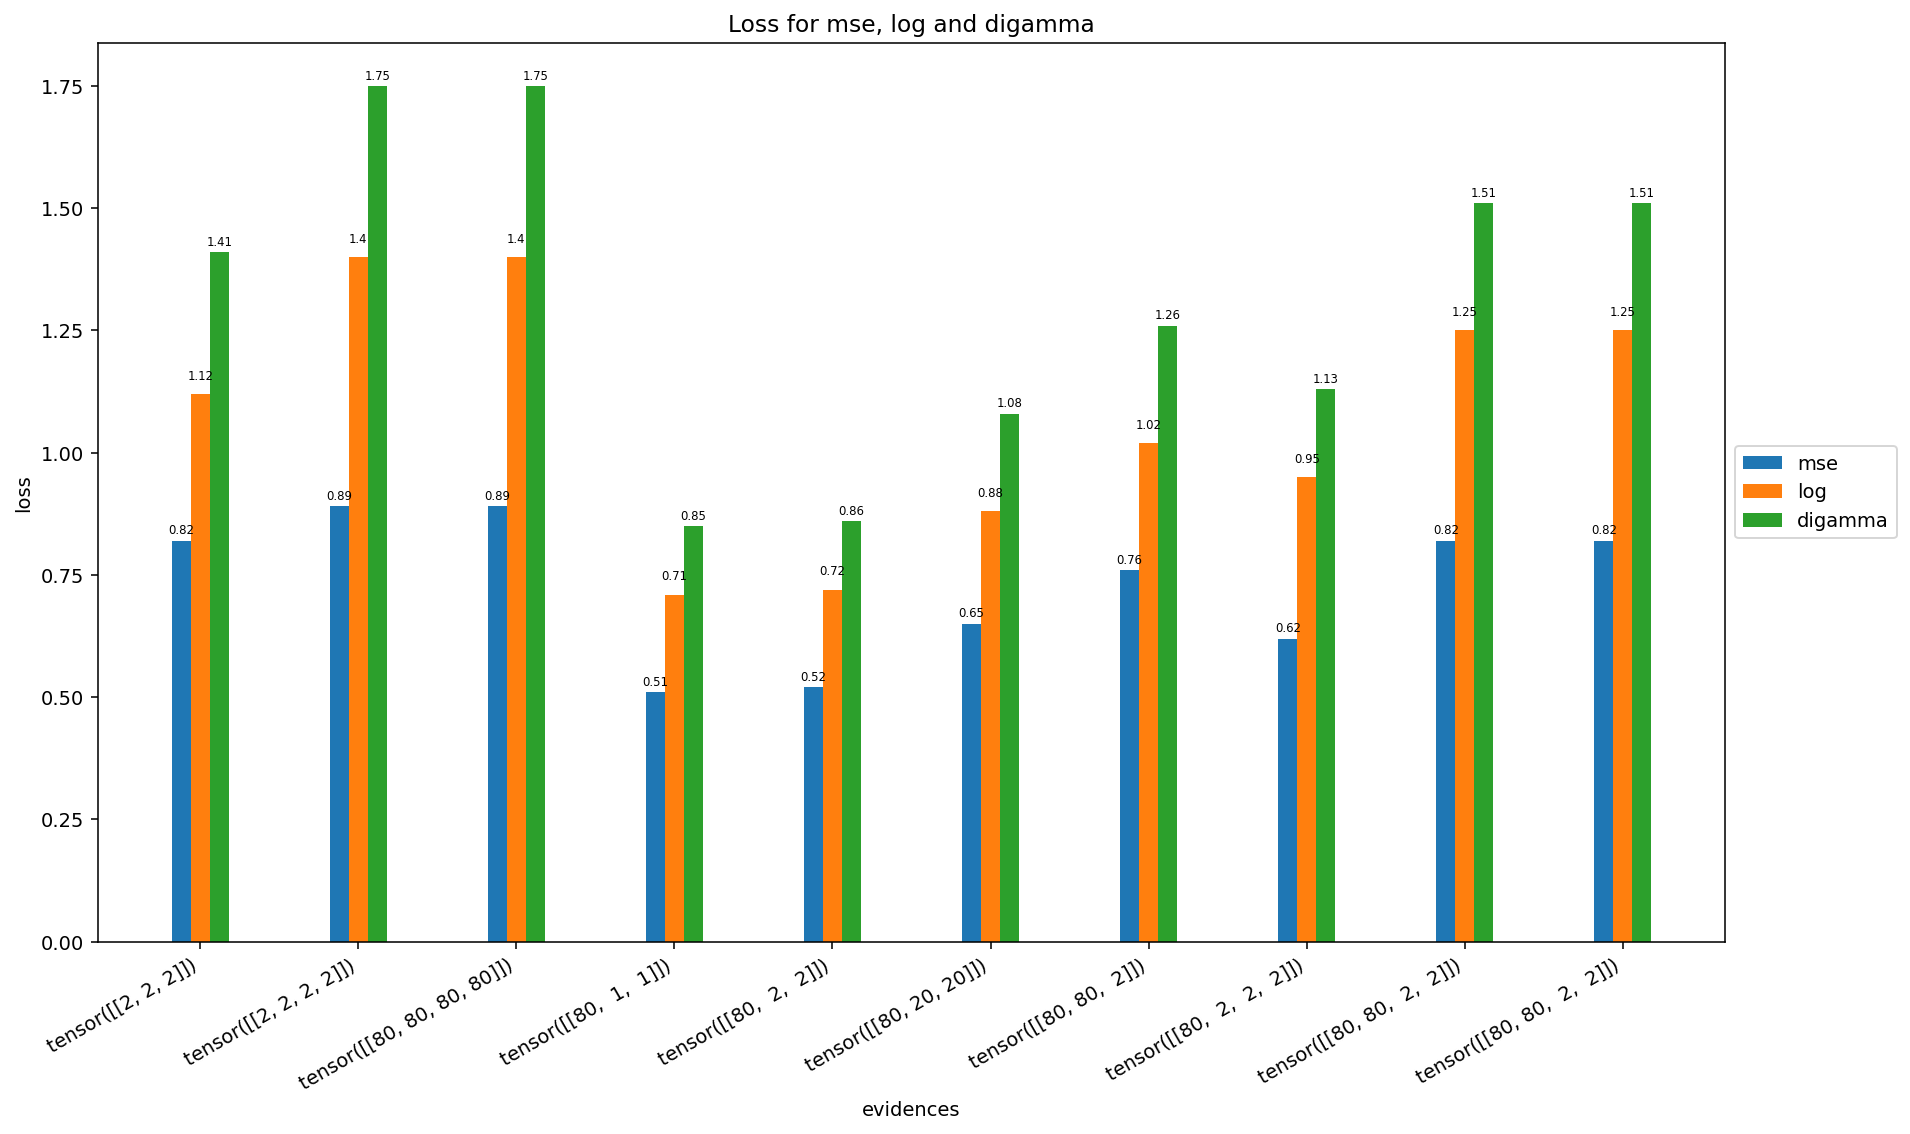

In [5]:
display(Markdown('**The label used for the experiment is [1,0,0] or [1,0,0,0]**'))
alpha = []
label = []
mse = []
log = []
digamma = []

alpha.append(torch.tensor([[2, 2, 2]]))
alpha.append(torch.tensor([[2, 2, 2, 2]]))
alpha.append(torch.tensor([[80, 80, 80, 80]]))
alpha.append(torch.tensor([[80, 1, 1]]))
alpha.append(torch.tensor([[80, 2, 2]]))
alpha.append(torch.tensor([[80, 20, 20]]))
alpha.append(torch.tensor([[80, 80, 2]]))
alpha.append(torch.tensor([[80, 2, 2, 2]]))
alpha.append(torch.tensor([[80, 80, 2, 2]]))
alpha.append(torch.tensor([[80, 80, 2, 2]]))

plot_labels = [str(x) for x in alpha]

for i in range(0, len(alpha)):
    alpha[i] = alpha[i] / alpha[i].sum(dim=1)
    label.append(torch.nn.functional.one_hot(torch.LongTensor([0]), num_classes=alpha[i].size()[1]))
    a, b, c = calc_loss(alpha[i], label[i], 1, alpha[i].size()[1])
    mse.append(float(a))
    log.append(float(b))
    digamma.append(float(c))



mse = [round(x,2) for x in mse]
log = [round(x,2) for x in log]
digamma = [round(x,2) for x in digamma]


x = np.arange(len(plot_labels)) 
width = 0.12
plt.rcParams["figure.figsize"] = (15,8.5)
plt.rcParams['figure.dpi'] = 140
fig, ax = plt.subplots()
rects1 = ax.bar(x-width, mse, width, label='mse')
rects2 = ax.bar(x, log, width, label='log')
rects3 = ax.bar(x+width, digamma, width, label='digamma')
ax.set_ylabel('loss')
ax.set_xlabel('evidences')
ax.set_title('Loss for mse, log and digamma')
ax.set_xticks(x, plot_labels, rotation=30, horizontalalignment='right')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.bar_label(rects1, padding=2, fontsize=6)
ax.bar_label(rects2, padding=6, fontsize=6)
ax.bar_label(rects3, padding=2, fontsize=6)
plt.show()

**The label used for the experiment is [1,1,0] or [1,1,0,0]**

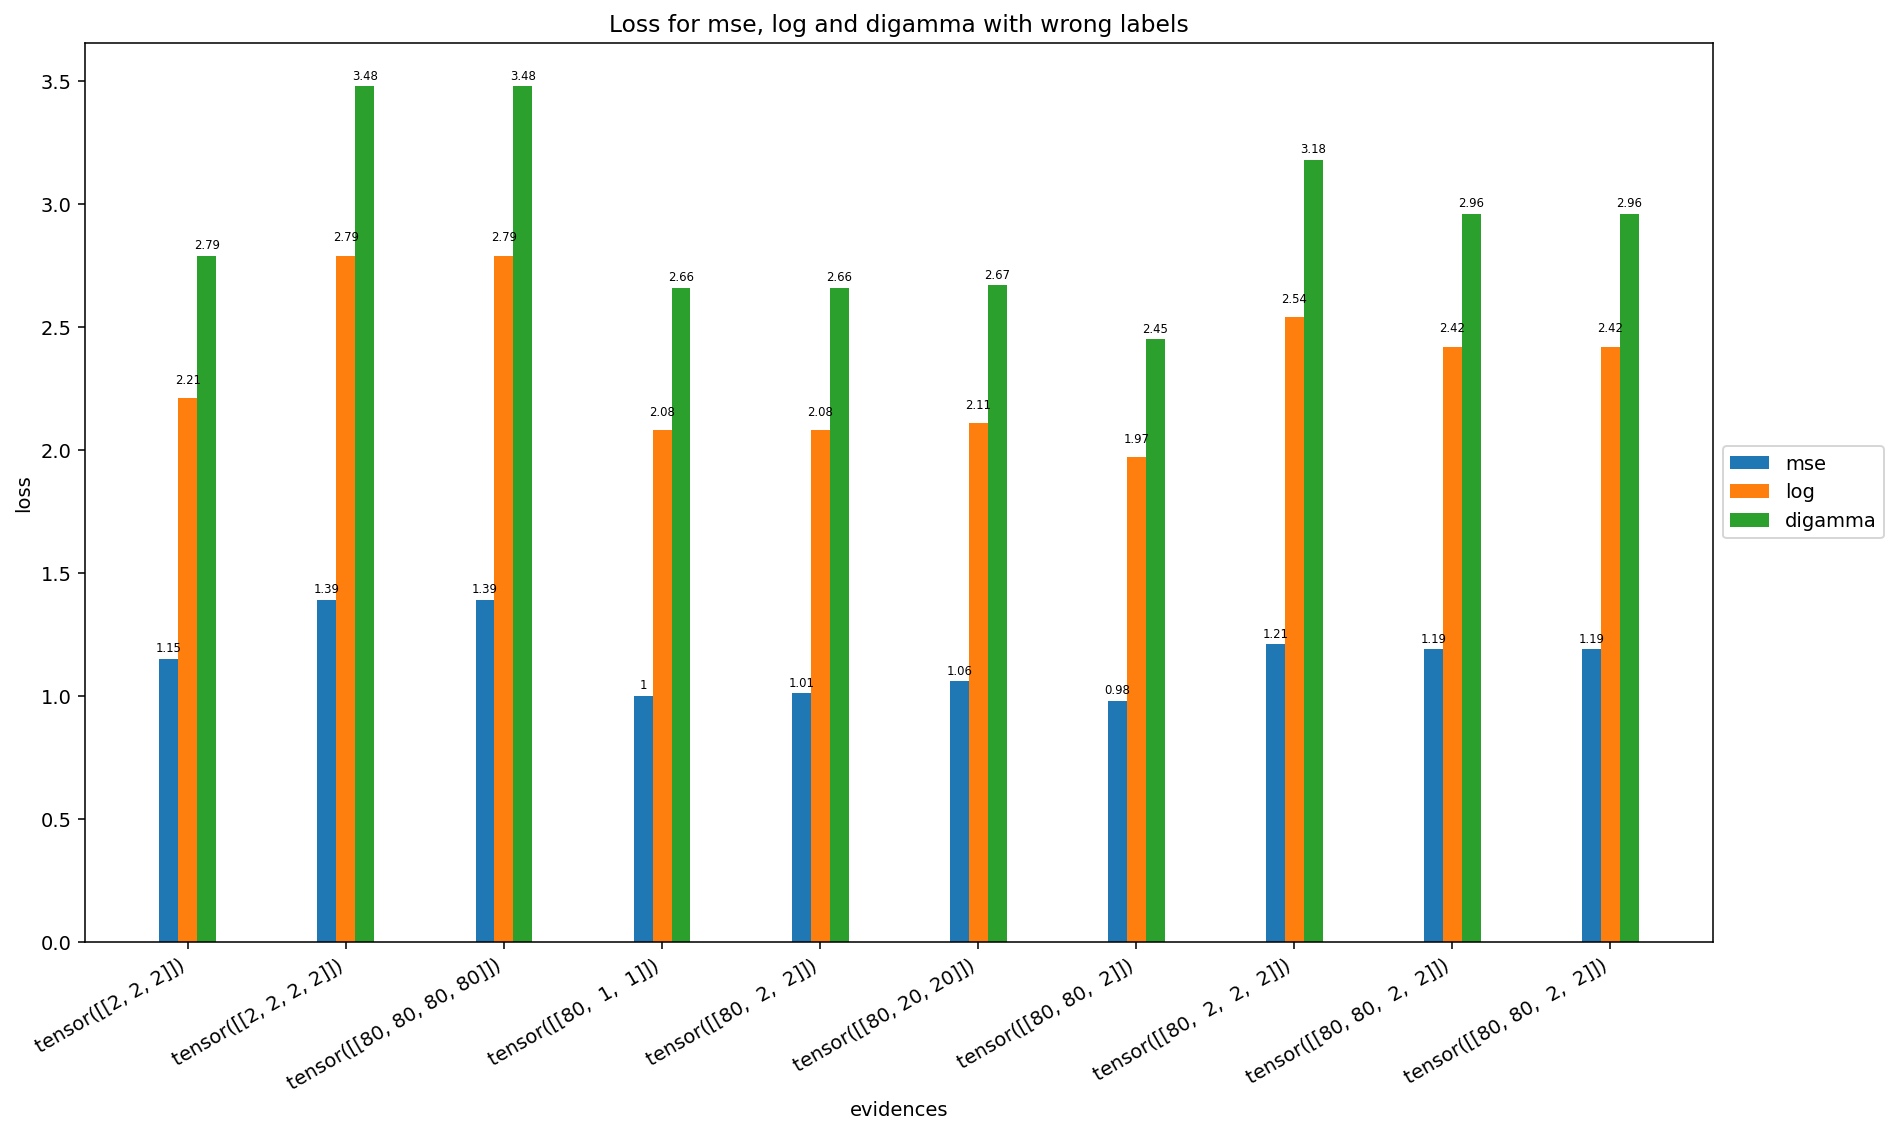

In [6]:
display(Markdown('**The label used for the experiment is [1,1,0] or [1,1,0,0]**'))
alpha = []
label = []
mse = []
log = []
digamma = []

alpha.append(torch.tensor([[2, 2, 2]]))
alpha.append(torch.tensor([[2, 2, 2, 2]]))
alpha.append(torch.tensor([[80, 80, 80, 80]]))
alpha.append(torch.tensor([[80, 1, 1]]))
alpha.append(torch.tensor([[80, 2, 2]]))
alpha.append(torch.tensor([[80, 20, 20]]))
alpha.append(torch.tensor([[80, 80, 2]]))
alpha.append(torch.tensor([[80, 2, 2, 2]]))
alpha.append(torch.tensor([[80, 80, 2, 2]]))
alpha.append(torch.tensor([[80, 80, 2, 2]]))

plot_labels = [str(x) for x in alpha]

for i in range(0, len(alpha)):
    alpha[i] = alpha[i] / alpha[i].sum(dim=1)
    if alpha[i].size()[1] == 4:
        label.append(torch.tensor([[1, 1, 0, 0]]))
    else:
        label.append(torch.tensor([[1, 1, 0]]))
    a, b, c = calc_loss(alpha[i], label[i], 1, alpha[i].size()[1])
    mse.append(float(a))
    log.append(float(b))
    digamma.append(float(c))



mse = [round(x,2) for x in mse]
log = [round(x,2) for x in log]
digamma = [round(x,2) for x in digamma]


x = np.arange(len(plot_labels)) 
width = 0.12
plt.rcParams["figure.figsize"] = (15,8.5)
plt.rcParams['figure.dpi'] = 140
fig, ax = plt.subplots()
rects1 = ax.bar(x-width, mse, width, label='mse')
rects2 = ax.bar(x, log, width, label='log')
rects3 = ax.bar(x+width, digamma, width, label='digamma')
ax.set_ylabel('loss')
ax.set_xlabel('evidences')
ax.set_title('Loss for mse, log and digamma with wrong labels')
ax.set_xticks(x, plot_labels, rotation=30, horizontalalignment='right')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.bar_label(rects1, padding=2, fontsize=6)
ax.bar_label(rects2, padding=6, fontsize=6)
ax.bar_label(rects3, padding=2, fontsize=6)
plt.show()

### Summary
* If the alpha values are uniform, the loss value remains same for a loss function with any alpha value. <br> Example: Evidential mse loss for evidence [2,2,2,2] and [80,80,80,80] are same
* If the alpha values are uniform, the loss value is high for evidence having the higher number of classes. <br> Example: Evidential mse loss for evidence [2,2,2,2] is higher than [2,2,2]
* The evidence for one class being relatively very high and the other classes with minimum values will have low loss. <br> Example: Evidential mse loss for evidence [80,1,1] is lower than [80,2,2] <br> Evidential mse loss for evidence [80,2,2] is lower than [80,,80,2]
* With one hot encoding, providing wrong labels gives an increased error for all three loss functions  <br> Example: Evidential mse loss for evidence [80,1,1] with label [1,0,0] is lower than [1,1,0]
* In general, the loss values are in the following order: mse < log < digamma 




**Results:** <br> 
From experiments, the following configuration provides better results
* Evidence with less number of classes
* Evidence value for one class being very high and other classes with as minimum as possible